In [35]:
## First step 
## Download the Spanish games corpus to a specific location
## Later, execute the code in sequence 
## This program reads each words file and creates a new words file with additional information about "speaker" and "filename".
## The program reads the .words file from each folder and creates a new words file with the extension .words_with_speaker
## For instance, s01.cards.1.A.words will be processed, and the new file will be created on the same path with s01.cards.1.A.words_with_speaker

#Program to add speaker and filename column in each word file
import os
import sys
import glob
import os.path
import pandas as pd
import re

list_of_files = glob.glob(r'D:\Jay\Spanish_games_corpus\dataset\B1\b1-dialogue-words\**\*.words',recursive=True) 

for file_name in list_of_files:    
    out_name=file_name+'_with_speaker'
    csv_input = pd.read_csv(file_name, delimiter='\s', header=None, index_col = False)
    csv_input['Speaker'] = file_name[-7]
    csv_input['filename'] = file_name
    csv_input.to_csv(out_name, index=False,header=False,sep=' ')

C:\Users\kejri\AppData\Local\Temp\ipykernel_5504\3119876180.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  csv_input = pd.read_csv(file_name, delimiter='\s', header=None, index_col = False)
C:\Users\kejri\AppData\Local\Temp\ipykernel_5504\3119876180.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  csv_input = pd.read_csv(file_name, delimiter='\s', header=None, index_col = False)
C:\Users\kejri\AppData\Local\Temp\ipykernel_5504\3119876180.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s

In [38]:
#Second step 
## The program reads each words_with_speaker file processed in the first step and combines the text files of both speakers in each session.
## For instance, s01.cards.1.A.words_with_speaker and s01.cards.1.B.words_with_speaker will be read and combined. 
## The output will be saved as s01.objects.1.A.words_with_speaker_txt
## The program also converts each flac file into wav file format
## For instance, s01.cards.1.A.flac will be transformed to s01.objects.1.A.wav

#Program to merge Speaker text files and convert flac files
import os
import fnmatch
import sys
import subprocess

#Specify path of dataset
OLD_BASE = r'D:\Jay\Spanish_games_corpus\dataset\B1'
#Create the empty folder where ouput needs to be saved
#Specify path of output folder
new_dir = r'D:\Jay\Spanish_games_corpus\dataset\B1_new'
# Specify input path  for wav files
object_wav = sorted(glob.glob(r'D:\Jay\Spanish_games_corpus\dataset\B1\**\*.wav',recursive=True)) 
# Build input path for word file generated in previous step
object_text = sorted(glob.glob(r'D:\Jay\Spanish_games_corpus\dataset\B1\**\*.words_with_speaker',recursive=True))

def merge_files(infiles):
    for i in range(0, len(infiles)-1,2):
        output=os.path.basename(infiles[i][:-9])+'txt'
        outfiletxt = os.path.join(new_dir, output)
        with open(outfiletxt, 'wb') as fo:
            with open(infiles[i], 'rb') as fi:
                fo.write(fi.read())
            with open(infiles[i+1], 'rb') as fi:
                fo.write(fi.read())

def convert_files(infiles):
    for i in range(0, len(infiles)-1,2):
        output_channel1=os.path.basename(infiles[i][:-3])+'wav'
        output_channel2=os.path.basename(infiles[i+1][:-3])+'wav'
        outfile1 = os.path.join(new_dir, output_channel1)
        outfile2 = os.path.join(new_dir, output_channel2)
        ffp=r"C:\ffmpeg-master-latest-win64-gpl\bin\ffmpeg"
        cmd2wav1 = ffp+' -i ' + infiles[i] + ' ' + "-ar 16000" + ' ' + outfile1
        cmd2wav2 = ffp+' -i ' + infiles[i+1] + ' ' + "-ar 16000" + ' ' + outfile2
        #print(cmd2wav)
        subprocess.call(cmd2wav1, shell=True)
        subprocess.call(cmd2wav2, shell=True)






# Merge
convert_files(object_wav)
merge_files(object_text)




In [46]:
#Third step 
## The program reads each concatenated words_with_speaker_txt file processed in the second step and further processes it in the following way.
## Each word consecutively spoken by a speaker is merged and converted into a turn.
## Similarly, start and end times are adjusted accordingly
## For instance, s01.objects.1.A.words_wittxt will be read and s01.objects.1.txt will be generated in same folder. 
#Program to extract turns
import os
import sys
import glob
import os.path
import pandas as pd

list_of_files = glob.glob(r'D:\Jay\Spanish_games_corpus\dataset\B1_new\**\*.words_wittxt',recursive=True) 

for file_name in list_of_files:    
    out_name=file_name[:-14]+'txt'
    headers= ['start','end','words','Speaker','filename']
    csv_input = pd.read_csv(file_name,delimiter=' ')
    csv_input.columns = headers
    #csv_input
    spa2=csv_input.sort_values(['start'])    
    spa3=spa2[spa2["words"].str.contains("#")==False]
    spa3[['start', 'end']] = spa3[['start', 'end']].astype(str)
    spa3['obj1_count'] = (spa3['Speaker'].ne(spa3['Speaker'].shift())).cumsum()
    df3=spa3.groupby('obj1_count').agg(lambda x: ' '.join(x))
    df3['start'] = df3['start'].map(lambda x: x.split(" ")[0])
    df3['end'] = df3['end'].map(lambda x: x.split(" ")[-1])
    df3['Speaker'] = df3['Speaker'].map(lambda x: x.split(" ")[-1])
    df3['filename'] = df3['filename'].map(lambda x: x.split(" ")[-1])
    df3['filename'] = df3['filename'].apply(lambda x: os.path.basename(x))
    df3['filename'] = df3['filename'].str.replace('words','wav')
    df3['session']=re.search('(\d\d)',file_name)[0]
    if df3.iloc[-1]['Speaker'] == df3.iloc[0]['Speaker']:
        df4=df3.drop(df3.index[len(df3)-1])
        df4.to_csv(out_name, index=False,header=False,sep='\t')
        del df4
    else:
        df3.to_csv(out_name, index=False,header=False,sep='\t')
    del csv_input,spa2,spa3,df3

C:\Users\kejri\AppData\Local\Temp\ipykernel_5504\567245619.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spa3[['start', 'end']] = spa3[['start', 'end']].astype(str)
C:\Users\kejri\AppData\Local\Temp\ipykernel_5504\567245619.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spa3['obj1_count'] = (spa3['Speaker'].ne(spa3['Speaker'].shift())).cumsum()
C:\Users\kejri\AppData\Local\Temp\ipykernel_5504\567245619.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [47]:
#Fourth step 
## Program to delete words_with_speaker_txt file
## The program deletes all the words_with_speaker_txt files generated in second step
## The program allows better readability of the generated output
## After executing the program, Each session folder will have two wav files and one txt file
## For instance, s01.objects.1.A.wav, s01.objects.1.B.wav and s01.objects.1.txt 
#Delete files with unwanted extension

import glob

#Delete files with unwanted extension
for f in glob.glob(r'D:\Jay\Spanish_games_corpus\dataset\B1_new\*.words_wittxt',recursive=True):
    os.remove(f)

In [1]:
#Fifth step 
## Program to extract textual, semantic and auditory embeddings from each turn
## The program reads each text file generated in the third step and extracts text, TRILL vectors and semantic embeddings from each turn
## The program saves embeddings in pkl file format

import pandas as pd
from sentence_transformers import SentenceTransformer, util
from transformers import BertTokenizer, BertModel
import torch
from functools import reduce
import csv
from sklearn.metrics.pairwise import cosine_similarity
import random
import subprocess
import re
import glob
import os,sys
import numpy as np
import soundfile as sf
import wave
import json
import tensorflow as tf1
import tensorflow_hub as hub
# Import TF 2.X and make sure we're running eager.
import tensorflow.compat.v2 as tf
#import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
modulev3=None
modulev3_graph=None
import pickle
tf.enable_v2_behavior()
assert tf.executing_eagerly()

##Function to load TRILL vector model     
def get_TRILLv3_signal(signal,samplerate):
    global modulev3
    if modulev3==None:
        #Specify the path of TRILL vector model
        print('******************\nLoading model ...\n******************')    
        modulev3 = hub.load(r'D:\Jay\columbia-games-corpus\trill_extraction_v2\v3')
    
    
    max_int16 = 2**15
    chunks_cnt=int(signal.shape[0]/(samplerate*10.0))#10 seconds max in chunk
    if chunks_cnt==0:
        chunks=[signal]
    else:
        chunks=np.array_split(signal, chunks_cnt)
    
    trillv3_emb_all=np.empty(shape=(0,512))
    
    for chunk in chunks:
        trillv3 = modulev3(samples=chunk, sample_rate=samplerate)
        trillv3_emb = trillv3['embedding']
        trillv3_emb_all=np.concatenate((trillv3_emb_all, trillv3_emb))

    trillv3_emb_avg = np.mean(trillv3_emb_all, axis=0, keepdims=False)

    return (trillv3_emb_avg.tolist())    

##Function to check if audio files are in proper format 
def check_wav_format(wav_file, start, end):
    wf = wave.open(wav_file)
    nchannels, sampwidth, framerate, nframes, comptype, compname = wf.getparams()
    print(nchannels, sampwidth, framerate, nframes, comptype, compname)
    wav_length = float(nframes) / float(framerate)
    print(wav_length)
    if nchannels!=1:
        print('Error: Incoming audio file has more then 1 channel')
        return(-1) 
				
    if framerate!=16000:
        print('Error: Incoming audio file sampling frequency must be 16000')
        return(-2)
				
    if sampwidth!=2:
        print('Error: Incoming audio file sample width must be 16 bit')
        return(-3)

    if wav_length<end:
        print('Error: The duration of the audio file is shorter than the required end time')
        return(-4)
		
    if start<0.0:
        print('Error: start time is lower then 0.0')
        return(-5)
    
    if start>=end:
        print('Error: start time is larger then end time')
        return(-6)    
		
				
    return(framerate)

##Function to extract TRILL embeddings from specific file name with start and end time as parameters  
def get_TRILLv3_audiofile_from_to(wav_file,start,end):
    print('get_TRILLv3_signal:',wav_file,start,end)
    samplerate=check_wav_format(wav_file, start, end)
    if samplerate<0:
        return(null)    
    startsample=int(start*samplerate)
    endsample=int(end*samplerate)
    signal, samplerate = sf.read(wav_file,start=startsample, stop=endsample)
    print(len(signal),samplerate)    

    trill=get_TRILLv3_signal(signal,samplerate)
    return(trill)

##Specify input path from where text files needs to be read
#Specify path for files generated in third step
path = r'D:\Jay\Spanish_games_corpus\dataset\B1_new'
#Specify path where auditory embeddings needs to be saved
audio_embedding_path = 'D:\\Jay\\Spanish_games_corpus\\dataset\\Pickle\\audio\\'
#Specify path where textual embeddings needs to be saved
text_embedding_path = 'D:\\Jay\\Spanish_games_corpus\\dataset\\Pickle\\text\\'
#Specify path where semantic embeddings needs to be saved
semantic_embedding_path = 'D:\\Jay\\Spanish_games_corpus\\dataset\\Pickle\\semantic\\'
#Initialize transformer model for semantic feature extraction
model = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')
all_files = os.listdir(path)

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.txt'):
            with open(os.path.join(root, file), 'r', encoding="utf8") as f:
                out_audio_embedding= os.path.join(audio_embedding_path, os.path.basename(file))
                out_semantic_embedding= os.path.join(semantic_embedding_path, os.path.basename(file))
                out_text_embedding= os.path.join(text_embedding_path, os.path.basename(file))
                sentenceembeddings=[]
                audioembeddings = []
                sentence_embeddings_tensor = []
                text = f.readlines()
                for line in text:
                    n1=line.split('\t')[0]
                    n2=line.split('\t')[1]
                    n3=line.split('\t')[4]
                    n4=os.path.join(root,n3)
                    sentence=line.split('\t')[2]
                    x=get_TRILLv3_audiofile_from_to(n4,float(n1),float(n2))
                    sentenceembeddings.append(sentence)
                    audioembeddings.append(x)
                sentence_embeddings_tensor = model.encode(sentenceembeddings, convert_to_tensor=False)
                sentence_embeddings_tensor=sentence_embeddings_tensor.tolist()
                with open(out_audio_embedding+'.pkl', 'wb') as f:
                    pickle.dump(audioembeddings, f)
                with open(out_text_embedding+'.pkl', 'wb') as f:
                    pickle.dump(sentenceembeddings, f)
                with open(out_semantic_embedding+'.pkl', 'wb') as f:
                    pickle.dump(sentence_embeddings_tensor, f)

get_TRILLv3_signal: D:\Jay\Spanish_games_corpus\dataset\B1_new\s09.objects.1.A.wav 0.852027 2.576032
1 2 16000 19167991 NONE not compressed
1197.9994375
27584 16000
******************
Loading model ...
******************
get_TRILLv3_signal: D:\Jay\Spanish_games_corpus\dataset\B1_new\s09.objects.1.B.wav 3.178447 3.52208
1 2 16000 19167991 NONE not compressed
1197.9994375
5498 16000
get_TRILLv3_signal: D:\Jay\Spanish_games_corpus\dataset\B1_new\s09.objects.1.A.wav 3.784647 8.945032
1 2 16000 19167991 NONE not compressed
1197.9994375
82566 16000
get_TRILLv3_signal: D:\Jay\Spanish_games_corpus\dataset\B1_new\s09.objects.1.B.wav 9.618119 10.098504
1 2 16000 19167991 NONE not compressed
1197.9994375
7687 16000
get_TRILLv3_signal: D:\Jay\Spanish_games_corpus\dataset\B1_new\s09.objects.1.A.wav 9.65101 12.900611
1 2 16000 19167991 NONE not compressed
1197.9994375
51993 16000
get_TRILLv3_signal: D:\Jay\Spanish_games_corpus\dataset\B1_new\s09.objects.1.B.wav 13.237868 13.595527
1 2 16000 19167991

In [2]:
#Sixth step 
## Program to measure lexical and syntactic entrainment
## The program takes two turns as input and provides cosine similarity as output

# ------------------------------------------------------------------------
# Name : Syntactic_and_Lexical_similarity_es.py
# Author : Jay Kejriwal
# Date   : 21-03-2022
# Description : Program to measure lexical and syntactic similarity between two sentences
# ------------------------------------------------------------------------

import stanza
import re
import math
from collections import Counter
import nltk
from nltk.util import ngrams
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')

def get_cosine(vec1, vec2):      #Function to measure cosine similarity
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])
    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)
    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(text,ngram):  #Function to measure lexical similarities in sentence
    n_grams = ngrams(nltk.word_tokenize(text), ngram)
    new_sequence1 =  [ ' '.join(grams) for grams in n_grams]
    return Counter(new_sequence1)


def process_lex_text(text):         #Function to remove punctuation and extrat lemma and pos
    words = re.sub(r'[.,"\-?:!;]', '', text.lower())
    doc = nlp(words)
    x=[f'{word.lemma}' for sent in doc.sentences for word in sent.words]
    return ' '.join([str(elem) for elem in x])


def process_syn_text(text):         #Function to remove punctuation and extrat lemma and pos
    words = re.sub(r'[.,"\-?:!;]', '', text.lower())
    doc = nlp(words)
    l=[f'{word.upos}' for sent in doc.sentences for word in sent.words]
    return ' '.join([str(elem) for elem in l])

def calculate_lexical_similarity(text1, text2):
    process1 = process_lex_text(text1)
    process2 = process_lex_text(text2)
    vector1 = text_to_vector(process1,ngram=1)
    vector2 = text_to_vector(process2,ngram=1)
    cosine = get_cosine(vector1, vector2)
    return cosine

def calculate_syntactic_similarity(text1, text2):
    process1 = process_syn_text(text1)
    process2 = process_syn_text(text2)
    vector1 = text_to_vector(process1,ngram=2)
    vector2 = text_to_vector(process2,ngram=2)
    cosin = get_cosine(vector1, vector2)
    return cosin


#text1 = "Mi nueva casa"
#text2 = "Mi nueva"

#print(calculate_lexical_similarity(text1, text2))
#print(calculate_syntactic_similarity(text1, text2))

2023-06-13 17:30:41 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-06-13 17:30:41 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2023-06-13 17:30:41 INFO: Using device: cpu
2023-06-13 17:30:41 INFO: Loading: tokenize
2023-06-13 17:30:41 INFO: Loading: mwt
2023-06-13 17:30:41 INFO: Loading: pos
2023-06-13 17:30:42 INFO: Loading: lemma
2023-06-13 17:30:42 INFO: Done loading processors!


0.8164965809277259
0.7071067811865475


In [3]:
#Seventh step 
## Program to measure entrainment distance using textual, semantic and auditory embeddings
## The program reads pkl file generated in the Fifth step and measures adjacent and non-adjacent scores at lexical, syntactic, semantic and acoustic levels
## The program also measures self score of both the speakers at all four linguistic levels
## The program generates a text file for each session with the following column information
### Same_pair_lexical [adjacent scores lexical] Not_Same_Pair_lexical [non-adjacent scores lexical]
### Same_pair_syntactic [adjacent scores lexical] Not_Same_Pair_syntactic [non-adjacent scores lexical]
### Same_pair_semantic [adjacent scores lexical] Not_Same_Pair_semantic [non-adjacent scores lexical]
### Same_pair_audio [adjacent scores acoustic]  Not_Same_Pair_audio [non-adjacent scores acoustic]  
###
### Speaker1_lexical_self_distance [Self score lexical Speaker 1] Speaker2_lexical_self_distance [Self score lexical Speaker 2]
### Speaker1_syntactic_self_distance [Self score syntactic Speaker 1] Speaker2_syntactic_self_distance [Self score syntactic Speaker 1]
### Speaker1_semantic_self_distance [Self score semantic Speaker 1] Speaker2_semantic_self_distance [Self score semantic Speaker 2]
### Speaker1_audio_self_distance    [Self score acoustic Speaker 1] Speaker2_audio_self_distance [Self score acoustic Speaker 2]


#Program to measure entrainment distance using cosine similarity

import pandas as pd
import csv
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import util
import random
import subprocess
import re
import glob
import os,sys
import numpy as np
import pickle
random.seed(223)


#Define path of embedding files generated in Fifth step 
audio_embedding_path = 'D:\\Jay\\Spanish_games_corpus\\dataset\\Pickle\\audio\\'
text_embedding_path = 'D:\\Jay\\Spanish_games_corpus\\dataset\\Pickle\\text\\'
semantic_embedding_path = 'D:\\Jay\\Spanish_games_corpus\\dataset\\Pickle\\semantic\\'

#Specify the output path where output needs to be saved
output_path = 'D:\\Jay\\Spanish_games_corpus\\dataset\\output'

for audiofile,textfile,semanticfile in zip(os.listdir(audio_embedding_path),os.listdir(text_embedding_path),os.listdir(semantic_embedding_path)):
        if audiofile.endswith(".pkl") & textfile.endswith(".pkl") & semanticfile.endswith(".pkl"):
            current_audiofile = os.path.join(audio_embedding_path,audiofile)
            current_textfile = os.path.join(text_embedding_path,textfile)
            current_semanticfile = os.path.join(semantic_embedding_path,semanticfile)

            output_filename= os.path.splitext(os.path.join(output_path, os.path.basename(audiofile)))[0]
            #Open audio, text and semantic pickle files
            with open(current_audiofile, 'rb') as a, open(current_textfile, 'rb') as b, open(current_semanticfile, 'rb') as c:
                audio_embeddings_tensor=pickle.load(a)
                sentence_embeddings_tensor=pickle.load(b)
                semantic_embeddings_tensor=pickle.load(c)

                sentence_embedding_random = []
                semantic_embedding_random = []
                audio_embedding_random = []
                
                lexical_speaker1=[]
                lexical_speaker2=[]
                syntactic_speaker1=[]
                syntactic_speaker2=[]
                semantic_speaker1=[]
                semantic_speaker2=[]
                audio_speaker1=[]
                audio_speaker2=[]
                
                same_pair_lexical = []
                not_samepairs_lexical_array = []
                not_samepairs_lexical=[]
                same_pairs_syntactic = []
                not_samepairs_syntactic_array = []
                not_samepairs_syntactic=[]
                same_pairs_semantic = []
                not_samepairs_semantic_array = []
                not_samepairs_semantic=[]
                same_pairs_audio = []
                not_samepairs_audio_array = []
                not_samepairs_audio=[]
                
                for i in range(0, len(sentence_embeddings_tensor)-1):
                    #Condition for random turns to exclude current and next turn 
                    sentence_embedding_random = [item for item in sentence_embeddings_tensor if np.logical_and(
                                                 item!=sentence_embeddings_tensor[i] , item != sentence_embeddings_tensor[i+1])]
                    audio_embedding_random = [item for item in audio_embeddings_tensor if np.logical_and(
                                                 item!=audio_embeddings_tensor[i] , item != audio_embeddings_tensor[i+1])]
                    semantic_embedding_random = [item for item in semantic_embeddings_tensor if np.logical_and(
                                                 item!=semantic_embeddings_tensor[i] , item != semantic_embeddings_tensor[i+1])]

                    if(i%2==0):
                        #Measure Partner distance for even turns
                        spl=calculate_lexical_similarity(sentence_embeddings_tensor[i],sentence_embeddings_tensor[i+1])
                        same_pair_lexical.append(spl)
                        spsy=calculate_syntactic_similarity(sentence_embeddings_tensor[i],sentence_embeddings_tensor[i+1])
                        same_pairs_syntactic.append(spsy)
                        sps=util.cos_sim(semantic_embeddings_tensor[i],semantic_embeddings_tensor[i+1]).item()
                        same_pairs_semantic.append(sps)
                        spa=util.cos_sim(audio_embeddings_tensor[i],audio_embeddings_tensor[i+1]).item()
                        same_pairs_audio.append(spa)
                        
                        for x in range(10):
                            #Measure Non-adjacent score for odd turns
                            #Here, mean Non-adjacent score is measured on 10 random turns
                            nspla=calculate_lexical_similarity(sentence_embeddings_tensor[i],sentence_embedding_random[random.randrange(1,len(sentence_embedding_random),2)])
                            not_samepairs_lexical_array.append(nspla)
                            nspsya=calculate_syntactic_similarity(sentence_embeddings_tensor[i],sentence_embedding_random[random.randrange(1,len(sentence_embedding_random),2)])
                            not_samepairs_syntactic_array.append(nspsya)
                            nspsa=util.cos_sim(semantic_embeddings_tensor[i],semantic_embedding_random[random.randrange(1,len(semantic_embedding_random),2)]).item()
                            not_samepairs_semantic_array.append(nspsa)
                            nspaa=util.cos_sim(audio_embeddings_tensor[i],audio_embedding_random[random.randrange(1,len(audio_embedding_random),2)]).item()
                            not_samepairs_audio_array.append(nspaa)

                        nspl = np.mean(not_samepairs_lexical_array)
                        nspsy = np.mean(not_samepairs_syntactic_array)
                        nsps = np.mean(not_samepairs_semantic_array)
                        nspa = np.mean(not_samepairs_audio_array)

                        not_samepairs_lexical_array = []
                        not_samepairs_syntactic_array = []
                        not_samepairs_semantic_array = []
                        not_samepairs_audio_array = []

                        not_samepairs_lexical.append(nspl)
                        not_samepairs_syntactic.append(nspsy)
                        not_samepairs_semantic.append(nsps)                       
                        not_samepairs_audio.append(nspa)

                    elif(i%2!=0):
                        #Measure Adjacent score for odd turns
                        spl=calculate_lexical_similarity(sentence_embeddings_tensor[i],sentence_embeddings_tensor[i+1])
                        same_pair_lexical.append(spl)
                        spsy=calculate_syntactic_similarity(sentence_embeddings_tensor[i],sentence_embeddings_tensor[i+1])
                        same_pairs_syntactic.append(spsy)
                        sps=util.cos_sim(semantic_embeddings_tensor[i],semantic_embeddings_tensor[i+1]).item()
                        same_pairs_semantic.append(sps)
                        spa=util.cos_sim(audio_embeddings_tensor[i],audio_embeddings_tensor[i+1]).item()
                        same_pairs_audio.append(spa)

                        
                        for x in range(10):
                            #Measure Non-adjacent score for odd turns
                            #Here, mean Non-adjacent score is measured on 10 random turns
                            nspla=calculate_lexical_similarity(sentence_embeddings_tensor[i],sentence_embedding_random[random.randrange(0,len(sentence_embedding_random),2)])
                            not_samepairs_lexical_array.append(nspla)
                            nspsya=calculate_syntactic_similarity(sentence_embeddings_tensor[i],sentence_embedding_random[random.randrange(0,len(sentence_embedding_random),2)])
                            not_samepairs_syntactic_array.append(nspsya)
                            nspsa=util.cos_sim(semantic_embeddings_tensor[i],semantic_embedding_random[random.randrange(0,len(semantic_embedding_random),2)]).item()
                            not_samepairs_semantic_array.append(nspsa)
                            nspaa=util.cos_sim(audio_embeddings_tensor[i],audio_embedding_random[random.randrange(0,len(audio_embedding_random),2)]).item()
                            not_samepairs_audio_array.append(nspaa)


                        nspl = np.mean(not_samepairs_lexical_array)
                        nspsy = np.mean(not_samepairs_syntactic_array)
                        nsps = np.mean(not_samepairs_semantic_array)
                        nspa = np.mean(not_samepairs_audio_array)

                        not_samepairs_lexical_array = []
                        not_samepairs_syntactic_array = []
                        not_samepairs_semantic_array = []
                        not_samepairs_audio_array = []

                        not_samepairs_lexical.append(nspl)
                        not_samepairs_syntactic.append(nspsy)
                        not_samepairs_semantic.append(nsps)                       
                        not_samepairs_audio.append(nspa)

                for n in range(0, len(sentence_embeddings_tensor)-2):
                    #Measure self-scores
                    if(n%2==0):
                        same_spkr1_lexical=calculate_lexical_similarity(sentence_embeddings_tensor[n],sentence_embeddings_tensor[n+2])
                        lexical_speaker1.append(same_spkr1_lexical)
                        same_spkr1_syntactic=calculate_syntactic_similarity(sentence_embeddings_tensor[n],sentence_embeddings_tensor[n+2])
                        syntactic_speaker1.append(same_spkr1_syntactic)
                        same_spkr1_semantic=util.cos_sim(semantic_embeddings_tensor[n],semantic_embeddings_tensor[n+2]).item()
                        semantic_speaker1.append(same_spkr1_semantic)
                        same_spkr1_audio=util.cos_sim(audio_embeddings_tensor[n],audio_embeddings_tensor[n+2]).item()
                        audio_speaker1.append(same_spkr1_audio)
                
                    elif(n%2!=0):
                        same_spkr2_lexical=calculate_lexical_similarity(sentence_embeddings_tensor[n],sentence_embeddings_tensor[n+2])
                        lexical_speaker2.append(same_spkr2_lexical)
                        same_spkr2_syntactic=calculate_syntactic_similarity(sentence_embeddings_tensor[n],sentence_embeddings_tensor[n+2])
                        syntactic_speaker2.append(same_spkr2_syntactic)
                        same_spkr2_semantic=util.cos_sim(semantic_embeddings_tensor[n],semantic_embeddings_tensor[n+2]).item()
                        semantic_speaker2.append(same_spkr2_semantic)
                        same_spkr2_audio=util.cos_sim(audio_embeddings_tensor[n],audio_embeddings_tensor[n+2]).item()
                        audio_speaker2.append(same_spkr2_audio)
                        
                df = pd.DataFrame(data=None)
                df['Same_pair_lexical'] = pd.Series(same_pair_lexical)
                df['Not_Same_Pair_lexical'] = pd.Series(not_samepairs_lexical)
                df['Same_pair_syntactic'] = pd.Series(same_pairs_syntactic)
                df['Not_Same_Pair_syntactic'] = pd.Series(not_samepairs_syntactic)
                df['Same_pair_semantic'] = pd.Series(same_pairs_semantic)
                df['Not_Same_Pair_semantic'] = pd.Series(not_samepairs_semantic)
                df['Same_pair_audio'] = pd.Series(same_pairs_audio)
                df['Not_Same_Pair_audio'] = pd.Series(not_samepairs_audio)

                df['Speaker1_lexical_self_distance'] = pd.Series(lexical_speaker1)
                df['Speaker2_lexical_self_distance'] = pd.Series(lexical_speaker2)
                df['Speaker1_syntactic_self_distance'] = pd.Series(syntactic_speaker1)
                df['Speaker2_syntactic_self_distance'] = pd.Series(syntactic_speaker2)
                df['Speaker1_semantic_self_distance'] = pd.Series(semantic_speaker1)
                df['Speaker2_semantic_self_distance'] = pd.Series(semantic_speaker2)
                df['Speaker1_audio_self_distance'] = pd.Series(audio_speaker1)
                df['Speaker2_audio_self_distance'] = pd.Series(audio_speaker2)

                df.insert(0, 'Turn_number', range(1, 1 + len(df)))
                df.to_csv(output_filename, index=False,sep='\t')
                
                sentence_embedding_random = []
                semantic_embedding_random = []
                audio_embedding_random = []
                lexical_speaker1=[]
                lexical_speaker2=[]
                syntactic_speaker1=[]
                syntactic_speaker2=[]
                semantic_speaker1=[]
                semantic_speaker2=[]
                audio_speaker1=[]
                audio_speaker2=[]
                same_pair_lexical = []
                not_samepairs_lexical_array = []
                not_samepairs_lexical=[]
                same_pairs_syntactic = []
                not_samepairs_syntactic_array = []
                not_samepairs_syntactic=[]
                same_pairs_semantic = []
                not_samepairs_semantic_array = []
                not_samepairs_semantic=[]
                same_pairs_audio = []
                not_samepairs_audio_array = []
                not_samepairs_audio=[]
                del df,spl,spsy,sps,spa,nspl,nspsy,nsps,nspa,same_spkr1_lexical,
                same_spkr1_semantic,same_spkr1_syntactic,same_spkr1_audio,same_spkr2_lexical,
                same_spkr2_semantic,same_spkr2_syntactic,same_spkr2_audio

         

In [1]:
#Eight step 
## Program to measure proximity, convergence and syncrony using adjacent, non-adjacent and self-score obtained in Seventh step
## The program reads text file generated in Seventh step and statistically analyzes the data using different methods 
## For instance, Proximity at lexical, syntactic, semantic and acoustic level
## The program generates text file with following column information for each session


### Proximity 
# Proximity-t-value_lexical	Proximity-p-value_lexical	Proximity-p-value_lexical_adj	
# Proximity-t-value_syntactic	Proximity-p-value_syntactic	Proximity-p-value_syntactic_adj	
# Proximity-t-value_semantic	Proximity-p-value_semantic	Proximity-p-value_semantic_adj	
# Proximity-t-value_audio	Proximity-p-value_audio	Proximity-p-value_audio_adj	
### Convergence 
# Convergence-Pearson rho_lexical	Convergence-Pearson p-value_lexical	Convergence-Pearson p-value_lexical_adj	
# Convergence-Pearson rho_syntactic	Convergence-Pearson p-value_syntactic	Convergence-Pearson p-value_syntactic_adj	
# Convergence-Pearson rho_semantic	Convergence-Pearson p-value_semantic	Convergence-Pearson p-value_semantic_adj	
# Convergence-Pearson rho_audio	Convergence-Pearson p-value_audio	Convergence-Pearson p-value_audio_adj	
### Synchrony
# Syncrony-Pearson rho_lexical	Syncrony-Pearson p-value_lexical	Syncrony-Pearson p-value_lexical_adj	
# Syncrony-Pearson rho_syntactic	Syncrony-Pearson p-value_syntactic	Syncrony-Pearson p-value_syntactic_adj	
# Syncrony-Pearson rho_semantic	Syncrony-Pearson p-value_semantic	Syncrony-Pearson p-value_semantic_adj	
# Syncrony-Pearson rho_audio	Syncrony-Pearson p-value_audio	Syncrony-Pearson p-value_audio_adj

import numpy as np
import pandas as pd
import scipy
import pingouin as pg
from scipy.stats import ttest_ind
from math import sqrt
import sys
from scipy import stats
import os
import sys
import glob
import os.path
import pandas as pd
from statsmodels.stats.multitest import multipletests

#Specify path of input files generated at sixth step
list_of_files = glob.glob(r'D:\Jay\Spanish_games_corpus\dataset\output\*.txt',recursive=True)

#Specify output path
output_path = r'D:\Jay\Spanish_games_corpus\dataset\statsoutput'

for file_name in list_of_files:
    out_name= os.path.join(output_path, os.path.basename(file_name))
    csv_input = pd.read_csv(file_name, delimiter='\t')
    
    #Proximity
    proximity_lexical=stats.ttest_rel(csv_input['Same_pair_lexical'], csv_input['Not_Same_Pair_lexical'])
    csv_input['Proximity-t-value_lexical']= proximity_lexical.statistic
    csv_input['Proximity-p-value_lexical']= proximity_lexical.pvalue
    #Here, Bonferroni correction is applied. Since there were 14 sessions we divided the significance value (0.05) by nr. of sessions
    csv_input['Proximity-p-value_lexical_adj'] = csv_input['Proximity-p-value_lexical'].lt(0.05/14)

    proximity_syntactic=stats.ttest_rel(csv_input['Same_pair_syntactic'], csv_input['Not_Same_Pair_syntactic'])
    csv_input['Proximity-t-value_syntactic']= proximity_syntactic.statistic
    csv_input['Proximity-p-value_syntactic']= proximity_syntactic.pvalue
    #Bonferroni correction
    csv_input['Proximity-p-value_syntactic_adj'] = csv_input['Proximity-p-value_syntactic'].lt(0.05/14)

    proximity_semantic=stats.ttest_rel(csv_input['Same_pair_semantic'], csv_input['Not_Same_Pair_semantic'])
    csv_input['Proximity-t-value_semantic']= proximity_semantic.statistic
    csv_input['Proximity-p-value_semantic']= proximity_semantic.pvalue
    #Bonferroni correction
    csv_input['Proximity-p-value_semantic_adj'] = csv_input['Proximity-p-value_semantic'].lt(0.05/14)

    proximity_audio=stats.ttest_rel(csv_input['Same_pair_audio'], csv_input['Not_Same_Pair_audio'])
    csv_input['Proximity-t-value_audio']= proximity_audio.statistic
    csv_input['Proximity-p-value_audio']= proximity_audio.pvalue
    #Bonferroni correction
    csv_input['Proximity-p-value_audio_adj'] = csv_input['Proximity-p-value_audio'].lt(0.05/14)
    
    #Convergence
    convlexr,convlexp = stats.pearsonr(csv_input['Same_pair_lexical'], csv_input['Turn_number'])
    csv_input['Convergence-Pearson rho_lexical'] = convlexr
    csv_input['Convergence-Pearson p-value_lexical'] = convlexp
    #Bonferroni correction
    csv_input['Convergence-Pearson p-value_lexical_adj'] = csv_input['Convergence-Pearson p-value_lexical'].lt(0.05/14)

    convsynr,convsynp = stats.pearsonr(csv_input['Same_pair_syntactic'], csv_input['Turn_number'])
    csv_input['Convergence-Pearson rho_syntactic'] = convsynr
    csv_input['Convergence-Pearson p-value_syntactic'] = convsynp
    #Bonferroni correction
    csv_input['Convergence-Pearson p-value_syntactic_adj'] = csv_input['Convergence-Pearson p-value_syntactic'].lt(0.05/14)

    convsemr,convsemp = stats.pearsonr(csv_input['Same_pair_semantic'], csv_input['Turn_number'])
    csv_input['Convergence-Pearson rho_semantic'] = convsemr
    csv_input['Convergence-Pearson p-value_semantic'] = convsemp
    #Bonferroni correction
    csv_input['Convergence-Pearson p-value_semantic_adj'] = csv_input['Convergence-Pearson p-value_semantic'].lt(0.05/14)

    convaudior,convaudiop = stats.pearsonr(csv_input['Same_pair_audio'], csv_input['Turn_number'])
    csv_input['Convergence-Pearson rho_audio'] = convaudior
    csv_input['Convergence-Pearson p-value_audio'] = convaudiop
    #Bonferroni correction
    csv_input['Convergence-Pearson p-value_audio_adj'] = csv_input['Convergence-Pearson p-value_audio'].lt(0.05/14)

    #Synchrony

    csv_input.dropna(inplace=True)
    synclexr,synclexp = stats.pearsonr(csv_input['Speaker1_lexical_self_distance'], csv_input['Speaker2_lexical_self_distance'])
    csv_input['Syncrony-Pearson rho_lexical'] = synclexr
    csv_input['Syncrony-Pearson p-value_lexical'] = synclexp
    #Bonferroni correction
    csv_input['Syncrony-Pearson p-value_lexical_adj'] = csv_input['Syncrony-Pearson p-value_lexical'].lt(0.05/14)

    syncsynr,syncsynp = stats.pearsonr(csv_input['Speaker1_syntactic_self_distance'], csv_input['Speaker2_syntactic_self_distance'])
    csv_input['Syncrony-Pearson rho_syntactic'] = syncsynr
    csv_input['Syncrony-Pearson p-value_syntactic'] = syncsynp
    #Bonferroni correction
    csv_input['Syncrony-Pearson p-value_syntactic_adj'] = csv_input['Syncrony-Pearson p-value_syntactic'].lt(0.05/14)
    
    syncsemr,syncsemp = stats.pearsonr(csv_input['Speaker1_semantic_self_distance'], csv_input['Speaker2_semantic_self_distance'])
    csv_input['Syncrony-Pearson rho_semantic'] = syncsemr
    csv_input['Syncrony-Pearson p-value_semantic'] = syncsemp
    #Bonferroni correction
    csv_input['Syncrony-Pearson p-value_semantic_adj'] = csv_input['Syncrony-Pearson p-value_semantic'].lt(0.05/14)

    syncaudior,syncaudiop = stats.pearsonr(csv_input['Speaker1_audio_self_distance'], csv_input['Speaker2_audio_self_distance'])
    csv_input['Syncrony-Pearson rho_audio'] = syncaudior
    csv_input['Syncrony-Pearson p-value_audio'] = syncaudiop
    #Bonferroni correction
    csv_input['Syncrony-Pearson p-value_audio_adj'] = csv_input['Syncrony-Pearson p-value_audio'].lt(0.05/14)
 

    csv_input.drop(['Same_pair_lexical', 'Not_Same_Pair_lexical', 'Same_pair_syntactic', 'Not_Same_Pair_syntactic',
                    'Same_pair_semantic', 'Not_Same_Pair_semantic', 'Same_pair_audio', 'Not_Same_Pair_audio',
                    'Speaker1_lexical_self_distance','Speaker2_lexical_self_distance','Turn_number','Speaker1_syntactic_self_distance',
                    'Speaker2_syntactic_self_distance','Speaker1_semantic_self_distance','Speaker2_semantic_self_distance',
                    'Speaker1_audio_self_distance','Speaker2_audio_self_distance'], axis=1,inplace=True)
    csv_input = csv_input.loc[[0]]
    csv_input.to_csv(out_name, index=False,sep='\t')
    del csv_input,proximity_lexical,proximity_syntactic,proximity_semantic,proximity_audio,
    convlexr,convlexp,convsynr,convsynp,convsemr,convsemp,convaudior,convaudiop,
    synclexr,synclexp,syncsynr,syncsynp,syncsemr,syncsemp,syncaudior,syncaudiop


In [ ]:
#Step Nine 
## Program to merge output files generated at Eight step
# The program concatenates statistical output of each inidividual sessions into one file
import pandas as pd
import glob
#Specify Input path for files generated in Eighth step
list_of_files = glob.glob(r'D:\Jay\Spanish_games_corpus\dataset\statsoutput\*.txt',recursive=True)
#Specify Output path
out_name = r'D:\Jay\Spanish_games_corpus\dataset\statsoutput\merged_stats.txt'
li = []

for filename in list_of_files:
    df = pd.read_csv(filename, index_col=None, header=0, delimiter='\t')
    basename = os.path.basename(filename)
    file_name = os.path.splitext(basename)[0]
    df['File_name'] = file_name
    #Re-arrange columns with filename as first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    #Define new arranged column to data-frame
    df = df[cols]
    #Append the dataframe to list
    li.append(df)
frame = pd.concat(li, axis=0, ignore_index=True) 

frame.to_csv(out_name, index=False,sep='\t')

In [2]:
#Step Ten
## Program to merge output files generated at Seventh step
# The program concatenates statistical output of each inidividual sessions into one file and further allows to measure correlation 
#Merge all output files and find correlation in next step

import pandas as pd
import glob,os
#Specify Input path for files generated in Eighth step
list_of_files = glob.glob(r'D:\Jay\Spanish_games_corpus\dataset\output\*.txt',recursive=True)

#Specify Output path
#Here file will be saved in csv format
out_name = r'D:\Jay\Spanish_games_corpus\dataset\output\combined_output'
li = []

for filename in list_of_files:
    df = pd.read_csv(filename, index_col=None, header=0, delimiter='\t')
    basename = os.path.basename(filename)
    file_name = os.path.splitext(basename)[0]
    df['File_name'] = file_name
    #Re-arrange columns with filename as first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    #Define new arranged column to data-frame
    df = df[cols]
    #Append the dataframe to list
    li.append(df)
frame = pd.concat(li, axis=0, ignore_index=True) 

frame.to_csv(out_name+'.csv', index=False,sep=',')

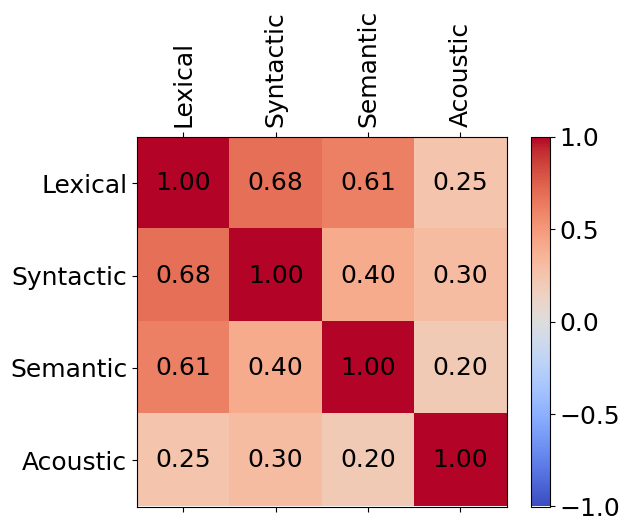

In [3]:
#Final Step 
## Program to find correlation between adjacent turns at lexical, syntactic, semantic and acoustic linguistic levels
## Find correlation using pearson correlation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
file_name=r'D:\Jay\Spanish_games_corpus\dataset\output\combined_output.csv'

df=pd.read_csv(file_name,delimiter=',')
df.rename(columns = {'Same_pair_lexical':'Lexical','Same_pair_syntactic':'Syntactic', 
                     'Same_pair_semantic':'Semantic', 'Same_pair_audio':'Acoustic'}, inplace = True)
group1=df[['Lexical','Syntactic','Semantic','Acoustic']]

corr = group1.corr()
corr
plt.rcParams.update({'font.size': 18})
ax.tick_params(axis='both', which='major', labelsize=14)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(group1.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(group1.columns)
ax.set_yticklabels(group1.columns)
for (i, j), z in np.ndenumerate(corr):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
plt.show()
